In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
noise_factor = 0.5
batch_size = 128
epochs = 50
num_display = 10
out_model = "denoising_ae_torch.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
x_train = torch.stack([img for img,_ in train_ds])
x_test = torch.stack([img for img,_ in test_ds])

In [4]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),  # latent vector
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.view(x.size(0), 1, 28, 28)
        return out

In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

x_train_noisy = torch.clamp(x_train + noise_factor * torch.randn_like(x_train), 0., 1.)
x_test_noisy  = torch.clamp(x_test  + noise_factor * torch.randn_like(x_test), 0., 1.)

train_loader = DataLoader(TensorDataset(x_train_noisy, x_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(x_test_noisy, x_test),  batch_size=batch_size, shuffle=False)

In [6]:
model = AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []
for epoch in range(1, epochs+1):
    model.train()
    running, count = 0.0, 0
    for xb_noisy, xb_clean in train_loader:
        xb_noisy, xb_clean = xb_noisy.to(device), xb_clean.to(device)
        optimizer.zero_grad()
        out = model(xb_noisy)
        loss = criterion(out, xb_clean)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb_noisy.size(0); count += xb_noisy.size(0)

    train_loss = running / count
    train_losses.append(train_loss)

    model.eval()
    running, count = 0.0, 0
    with torch.no_grad():
        for xb_noisy, xb_clean in test_loader:
            xb_noisy, xb_clean = xb_noisy.to(device), xb_clean.to(device)
            out = model(xb_noisy)
            loss = criterion(out, xb_clean)
            running += loss.item() * xb_noisy.size(0)
            count += xb_noisy.size(0)

    val_loss = running / count
    val_losses.append(val_loss)

    print(f"Epoch {epoch}/{epochs} — train_loss {train_loss:.6f}, val_loss {val_loss:.6f}")

Epoch 1/50 — train_loss 0.066134, val_loss 0.049859
Epoch 2/50 — train_loss 0.040566, val_loss 0.036054
Epoch 3/50 — train_loss 0.033676, val_loss 0.031175
Epoch 4/50 — train_loss 0.030048, val_loss 0.028604
Epoch 5/50 — train_loss 0.027937, val_loss 0.027162
Epoch 6/50 — train_loss 0.026485, val_loss 0.025638
Epoch 7/50 — train_loss 0.025312, val_loss 0.024695
Epoch 8/50 — train_loss 0.024332, val_loss 0.023873
Epoch 9/50 — train_loss 0.023460, val_loss 0.023041
Epoch 10/50 — train_loss 0.022727, val_loss 0.022330
Epoch 11/50 — train_loss 0.022033, val_loss 0.022093
Epoch 12/50 — train_loss 0.021541, val_loss 0.021378
Epoch 13/50 — train_loss 0.021090, val_loss 0.021189
Epoch 14/50 — train_loss 0.020623, val_loss 0.020714
Epoch 15/50 — train_loss 0.020200, val_loss 0.020250
Epoch 16/50 — train_loss 0.019827, val_loss 0.019946
Epoch 17/50 — train_loss 0.019476, val_loss 0.019695
Epoch 18/50 — train_loss 0.019167, val_loss 0.019362
Epoch 19/50 — train_loss 0.018906, val_loss 0.019331
Ep

Средняя MSE: 0.016390495


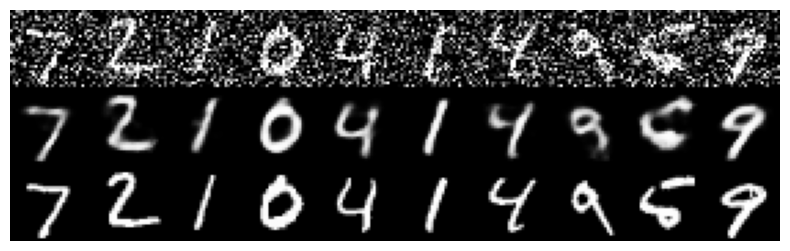

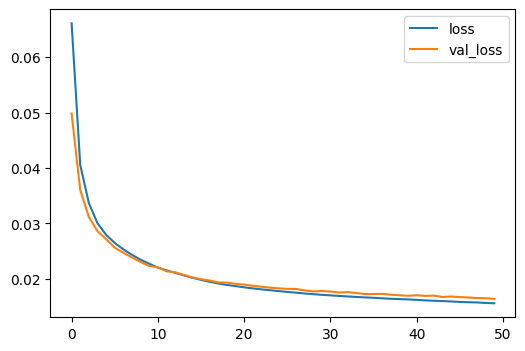

In [7]:
model.eval()
with torch.no_grad():
    decoded = model(x_test_noisy.to(device)).cpu().numpy()
x_test_np = x_test.numpy()
mse_all = np.mean((decoded - x_test_np)**2)
print("Средняя MSE:", mse_all)

display_n = min(num_display, decoded.shape[0])
rows = []
for i in range(display_n):
    noisy = (x_test_noisy[i].numpy().squeeze() * 255).astype(np.uint8)
    den   = (decoded[i].squeeze() * 255).astype(np.uint8)
    clean = (x_test_np[i].squeeze() * 255).astype(np.uint8)
    vert = np.vstack([noisy, den, clean])
    rows.append(vert)
grid = np.hstack(rows)
plt.figure(figsize=(display_n, 3))
plt.axis('off')
plt.imshow(grid, cmap='gray', vmin=0, vmax=255)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
plt.show()